# Naive Bayes on Amazon Fine Foods Reviews 

**Objective** - Run Naive Bayes Algorithms on Amazon Fine Foods Review Dataset using BoW and TF-IDF vectorization methods. Also to report the metrics for each iteration. Time based splitting to be followed.


**Kaggle Dataset Location** - https://www.kaggle.com/snap/amazon-fine-food-reviews/data



In [1]:
#Making Sure Warnings Dont Appear in Cell Outputs
import warnings
warnings.filterwarnings('ignore')


In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.naive_bayes import MultinomialNB

/usr/lib/python3/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**1. Importing Dataset from database.sqlite and ignoring reviews with Score  = 3 as they represent a neutral view**

In [3]:
# creating sql connection string
con = sqlite3.connect('AmazonReviews.sqlite')

In [4]:
#Positive Review - Rating above 3
#Negative Review - Rating below 3
#Ignoring Reviews with 3 Rating

filtered_data = pd.read_sql_query('SELECT * from Reviews WHERE Score != 3',con)

In [5]:
# mapping ratings above 3 as Positive and below 3 as Negative

actual_scores = filtered_data['Score']
positiveNegative = actual_scores.map(lambda x: 'Positive' if x>3 else 'Negative')
filtered_data['Score'] = positiveNegative

**3. Data Preprocessing**

In [6]:
# Making sure to drop duplicate reviews which are given by the same user at the same time with same text
final = filtered_data.drop_duplicates(subset= { 'UserId', 'ProfileName', 'Time',  'Text'})

In [7]:
# Check the percentage of datapoints remaining after dropping duplicates
print('Rows dropped : ',filtered_data.size - final.size)
print('Percentage Data remaining after dropping duplicates :',(((final.size * 1.0)/(filtered_data.size * 1.0) * 100.0)))

Rows dropped :  1616410
Percentage Data remaining after dropping duplicates : 69.25890143662969


In [8]:
# Dropping rows where HelpfulnessNumerator > HelpfulnessDenominator
# HelpfulnessNumerator  HelpfulnessDenominator
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
print('Number of Rows remaining in the Dataset: ',final.size)

Number of Rows remaining in the Dataset:  3641710


In [10]:
# Checking the number of positive and negative reviews
final['Score'].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [11]:
# Data Sampling to be done if required
#final = final.iloc[:80000,:]

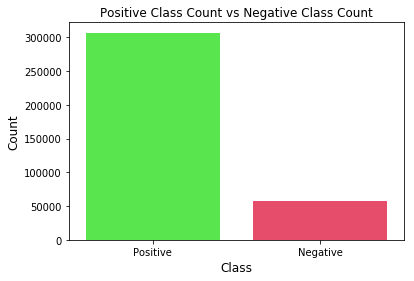

Positive    307061
Negative     57110
Name: Score, dtype: int64


In [12]:
# Checking the number of positive and negative reviews

Class_Count  = final['Score'].value_counts()

plt.figure()
flatui = ["#15ff00", "#ff0033"]
sns.set_palette(flatui)
sns.barplot(Class_Count.index, Class_Count.values, alpha=0.8 )
plt.title('Positive Class Count vs Negative Class Count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.show()

print(final['Score'].value_counts())

The Dataset is highly Imbalanced with Positive Class being the Majority Class

#### 4. Time Based Slicing
Since the Reviews may change with time, it is always advisable to apply time-based slicing.

In [13]:
# Sorting values according to Time for Time Based Slicing
final = final.sort_values('Time',kind = 'quicksort')

#### 5. Clean the Reviews Text 
Clean the Reviews Text before applying Naive Bayes Algorithm using techniques such a Stemming,Stop-Words removal and finally removing al html tags and special characters

In [14]:
# Function to Remove HTML Tags
def cleanhtml(sentence):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner,"",sentence)
    return cleantext

In [15]:
# Function to clean punctuations and special characters

def cleanpunct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [16]:
# Initialize Stop words and PorterStemmer and Lemmetizer
stop = set(stopwords.words('english'))
sno = SnowballStemmer('english')


#print(stop)
#print('*' * 100)
#print(sno.stem('tasty'))

In [17]:

# Cleaning HTML and non-Alphanumeric characters from the review text
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|██████████| 364171/364171 [07:23<00:00, 821.44it/s] 


In [18]:
# Add the cleaned reviews as a new column to the DataFrame
final['CleanedText']=final_string
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


### 6.Naive Bayes Algorithm

In [19]:
#Dictionary for storing Metrics
Final_Metrics =pd.DataFrame()
Final_List = []

In [20]:

# Function for Naive Bayes
def runNB(X_Train,X_Test,y_train,y_test,VectorizationType,count_vect):
    global Final_Metrics
    # to store the cv scores after 10-fold Cross Validation
    cv_scores = []
    # to store the Alpha scores after 10-fold Cross Validation
    k_value = []
    
    Train_Scores = []
    Test_Scores = []
    
    #algorithm = ['kd_tree','brute']
    algo = 'Naive Bayes'
        
    
    j=0    
    for i in range(2,30,2):
        # instantiate learning model (k = 30)
        nb = MultinomialNB(alpha=i)
        #print(i,X_Train,y_train)
        scores = cross_val_score(nb, X_Train, y_train, cv=10, scoring='accuracy')
        #print(scores)
        cv_scores.append(scores.mean())
        k_value.append(i)
        #print(i,' ',scores.mean())

        
        print('For Alpha = ', i,'Accuracy Score = ', cv_scores[j])
        
        j+=1
        #print(max(cv_scores))
    #print('CV SCore',cv_scores)
    
    #get the optimum alpha value after 10-Fold CV
    alpha_optimum = k_value[cv_scores.index(max(cv_scores))]
    
    # Plot the Alpha vs CV Score 
    plt.plot(k_value,cv_scores,'-o')
    plt.xlabel('Alpha Value')
    plt.ylabel('CV-Scores')
    plt.title('Alpha Value vs CV-Scores')
    print('*' * 300)
    #print('Max CV',max(cv_scores))
    #print('Index',cv_scores.index(max(cv_scores)) )
    #print('K_Value', k_value[cv_scores.index(max(cv_scores))])
    #print(alpha_optimum,'Alpha Opt')

    nb = MultinomialNB(alpha=alpha_optimum)
        # fitting the model on crossvalidation train
    nb.fit(X_Train, y_train)

        # predict the response on the crossvalidation train
    pred = nb.predict(X_Test)
    
    
    #Logic to implement Feature Importance
    #The probability values are sorted to get the most important features for each class
    neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
    pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()

    
    # Prints out the Important Features for both Positive and Negative Class
    print("Feature Importance for Negative Class: ",np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
    print("Feature Importance for Positive Class: ",np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

        # evaluate CV accuracy
        #acc = accuracy_score(y_cv_input, pred, normalize=True) * float(100)
    print('\nDetails for ',VectorizationType,'Vectorization:')
    print('*'*100)
    print('Accuracy for',algo,' algorithm with alpha =',alpha_optimum,' is ' ,np.round((accuracy_score(y_test, pred)*100),decimals = 2))
    print('F1 score for',algo,' algorithm with alpha =',alpha_optimum,' is ' , np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Recall for',algo,' agorithm with alpha =',alpha_optimum,' is ' , np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Precision for',algo,' algorithm with aplha =',alpha_optimum,' is ' , np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print ('\n Classification report for',algo,' algorithm with alpha =',alpha_optimum,' is \n ' , classification_report(y_test,pred))
    #print ('\n Confusion matrix for',algo,' algorithm with alpha =',alpha_optimum,' is \n' ,confusion_matrix(y_cv_input, pred))
    
    Train_Scores.append(nb.score(X_Train, y_train))
    Test_Scores.append(nb.score(X_Test, y_test))
      
    Temp_List = [algo,VectorizationType,alpha_optimum,nb.score(X_Train, y_train)*100,nb.score(X_Test, y_test)*100]
        #print(Temp_List)
    Final_Metrics = Final_Metrics.append({'Algorithm': algo,'Vectorization':VectorizationType,'HyperParameter':alpha_optimum,
                                              'Training Accuracy Score': nb.score(X_Train, y_train)*100,
                                              'Testing Accuracy Score':nb.score(X_Test, y_test)*100},
                                            ignore_index=True)
    
    
    # Plotting the Confusion Matrix
    plt.figure()
    confusion_matrix_Plot = confusion_matrix(y_test,pred)
    heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 7. Text Vectorization Techniques
#### A. Bag of Words

In [21]:
#Splitting into Training and Testing Set, and using only Training set for Word2Vec Training
X_Train,X_Test,y_train,y_test = train_test_split(final['CleanedText'],final['Score'])

In [22]:
# BoW Vectorization

vect = CountVectorizer().fit(X_Train)
X_Train = vect.transform(X_Train)
X_Test = vect.transform(X_Test)

For Alpha =  2 Accuracy Score =  0.9025182246913804
For Alpha =  4 Accuracy Score =  0.8964954083506147
For Alpha =  6 Accuracy Score =  0.8858630406080612
For Alpha =  8 Accuracy Score =  0.875091533449401
For Alpha =  10 Accuracy Score =  0.8664545601611676
For Alpha =  12 Accuracy Score =  0.8596775152358044
For Alpha =  14 Accuracy Score =  0.8550496486858516
For Alpha =  16 Accuracy Score =  0.8515457951862011
For Alpha =  18 Accuracy Score =  0.8491110342250495
For Alpha =  20 Accuracy Score =  0.8473572795931181
For Alpha =  22 Accuracy Score =  0.846152719220439
For Alpha =  24 Accuracy Score =  0.8453142874154148
For Alpha =  26 Accuracy Score =  0.8445930145966596
For Alpha =  28 Accuracy Score =  0.8441207078742421
************************************************************************************************************************************************************************************************************************************************************************

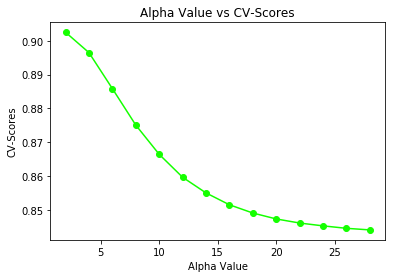

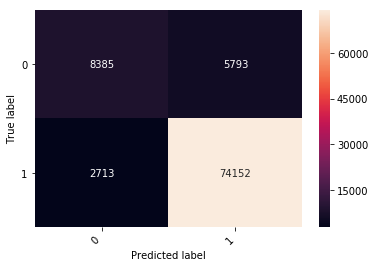

In [23]:
runNB(X_Train,X_Test,y_train,y_test,'Bag of Words',vect)


#### Using 10-Fold cross validation, the optimal Alpha value was set to 2. Using this Alpha value, the Naive Bayes Algorithm was run on the BOW vectorized  text data to get an accuracy of 90.66%. The Function also returns the other metrics like F1 Score,Precision and Recall, along with the Classification Report. The Confusion Matrix is also plotted using HeatMap.

#### B. Using TF-IDF

In [24]:
#Splitting into Training and Testing Set
X_Train,X_Test,y_train,y_test = train_test_split(final['CleanedText'],final['Score'])

In [25]:
# Using on TRain Dataset for fitting the TFIDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_Train = tf_idf_vect.fit_transform(X_Train.values)

# Using TRain fitted TFIDF to transform Test Dataset
tfidf_Test = tf_idf_vect.transform(X_Test.values)

In [26]:
#Check the structure of TFIDF transformed Train Dataset
print("the type of count vectorizer ",type(tfidf_Train))
print("the shape of out text TFIDF vectorizer ",tfidf_Train.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_Train.get_shape()[1])


#Check the structure of TFIDF transformed Test Dataset
print("the type of count vectorizer ",type(tfidf_Test))
print("the shape of out text TFIDF vectorizer ",tfidf_Test.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_Test.get_shape()[1])

X_train_Vectorised = tfidf_Train
X_test_Vectorised = tfidf_Test

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (273128, 2501383)
the number of unique words including both unigrams and bigrams  2501383
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (91043, 2501383)
the number of unique words including both unigrams and bigrams  2501383


For Alpha =  2 Accuracy Score =  0.8426964650525643
For Alpha =  4 Accuracy Score =  0.8426891423980996
For Alpha =  6 Accuracy Score =  0.8426891423980996
For Alpha =  8 Accuracy Score =  0.8426891423980996
For Alpha =  10 Accuracy Score =  0.8426891423980996
For Alpha =  12 Accuracy Score =  0.8426891423980996
For Alpha =  14 Accuracy Score =  0.8426891423980996
For Alpha =  16 Accuracy Score =  0.8426891423980996
For Alpha =  18 Accuracy Score =  0.8426891423980996
For Alpha =  20 Accuracy Score =  0.8426891423980996
For Alpha =  22 Accuracy Score =  0.8426891423980996
For Alpha =  24 Accuracy Score =  0.8426891423980996
For Alpha =  26 Accuracy Score =  0.8426891423980996
For Alpha =  28 Accuracy Score =  0.8426891423980996
**********************************************************************************************************************************************************************************************************************************************************************

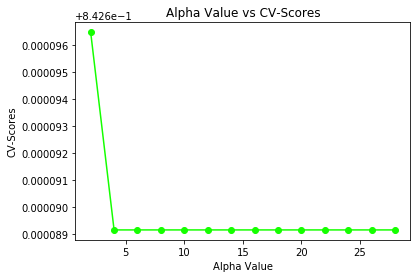

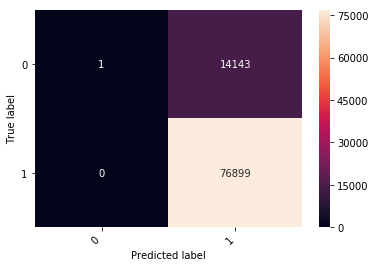

In [27]:
runNB(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'TF-IDF',tf_idf_vect)

#### Using 10-Fold cross validation, the optimal Alpha value was set to 2. Using this Alpha value, the Naive Bayes Algorithm was run on the TFIDF vectorized  text data to get an accuracy of 84.47%. The Function also returns the other metrics like F1 Score,Precision and Recall, along with the Classification Report. The Confusion Matrix is also plotted using HeatMap.

### 8. Other Vectorization Techniques
#### Other vectorization techniques like Average Word2Vec and TFIDF Weighted Word2Vec are not used because they consider the relation between words forming the text. Since, the major assumption of Naive Bayes is Independence of Features, it will not be fruitful emplying Naive Bayes on the above vectorization techniques.

### 9. Results

In [28]:
# Plotting the table showing comparison between the two vectorization techniques
Final_Metrics

,Algorithm,HyperParameter,Testing Accuracy Score,Training Accuracy Score,Vectorization
0,Naive Bayes,2.0,90.657162,91.047787,Bag of Words
1,Naive Bayes,2.0,84.465582,84.271111,TF-IDF


**The Above table shows that Naive Bayes Algorithm run using Bag of Words Vectorization technique results in the highest Testing Accuracy of 90.657162%  with an Alpha Value of 2.**

### 10. Conclusion
#### This Notebook goes through the follwoing steps -
1. Importing Packages
2. Importing Dataset
3. Data Pre-Processing
4. Text Cleaning
5. Vectorization of Text Data
6. Finding the Optimal Hyperparameter value using k-Fold CV
7. Applying Naive Bayes Algorithm
8. Plotting the metrics
9. Comparison of metrics of various vectorization techniques